In [90]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from thefuzz import fuzz
import os
import sys
sys.path.append('../')
import utils
import numpy as np
import matplotlib.pyplot as plt
import sklearn.cluster as cluster
from sklearn.preprocessing import MinMaxScaler

In [91]:
def normalize(s): 
    replacements = (
        ("á", "a"),
        ("à", "a"),
        ("ä", "a"),
        ("é", "e"),
        ("è", "e"),
        ("ë", "e"),
        ("í", "i"),
        ("ì", "i"),
        ("ï", "i"),
        ("ó", "o"),
        ("ò", "o"),
        ("ö", "o"),
        ("ú", "u"),
        ("ù", "u"),
        ("ü", "u")
    )

    for a, b in replacements:
        s = s.replace(a, b).replace(a.upper(), b.upper())
    return s

# Datos Renta

In [168]:
data = pd.read_csv('../data/renta_media.csv', sep=';')
data= data.query('Periodo == 2019 and Total != "." and `Indicadores de renta media`=="Renta bruta media por hogar"')

data.drop(['Indicadores de renta media', 'Periodo'], axis=1, inplace=True)
data.dropna(axis=0, how='any', inplace=True)

data.rename(columns={'Unidades territoriales': 'Nombre'}, inplace=True)
data['CCPP'] = data['Nombre'].apply(lambda x: x.split(' ')[0])
mask = data['CCPP'].str.len() == 5
data = data.loc[mask]
data['Nombre'] = data['Nombre'].apply(lambda x: x.split(' ', 1)[1])
data.query('CCPP=="40001"')
data.Total = data.Total.apply(lambda x: x.replace('.', '').replace(',','.'))
data.Total = pd.to_numeric(data.Total)
data['Nombre'] = data['Nombre'].astype('str')
data['CCPP'] = data['CCPP'].astype('str') 

data = data.groupby(['Nombre', 'CCPP']).Total.sum().reset_index()
data.sort_values(by='Total', ascending=False, inplace=True)
data.reset_index(drop=True, inplace=True)

df_pob = pd.read_excel('../data/pobmun20.xlsx')
df_pob.columns = df_pob.iloc[0]
df_pob = df_pob.iloc[1:]
df_pob = df_pob[['NOMBRE', 'POB20']]
data = data.merge(df_pob, left_on='Nombre', right_on='NOMBRE')

data['Nombre'] = data['Nombre'].str.lower()
data['Nombre'] = data['Nombre'].apply(normalize)
data.Nombre = data.Nombre.replace(utils.NAME_DICT)
data.rename(columns={'POB20': 'Poblacion'}, inplace=True)
data = data.query('Poblacion > 20000')

# Casas de Apuestas

In [169]:
df_cod = pd.read_csv('../data/locales_codere.csv')
df_cod['MUNICIPIO'] = ''
df_cod.loc[df_cod['NOMBRE_LOCAL'].str.contains('\('), 'MUNICIPIO'] = df_cod.loc[df_cod['NOMBRE_LOCAL'].str.contains('\(')].NOMBRE_LOCAL.apply(lambda x: x.split('(')[1])
df_cod.loc[~df_cod['NOMBRE_LOCAL'].str.contains('\('), 'MUNICIPIO'] = df_cod.loc[~df_cod['NOMBRE_LOCAL'].str.contains('\(')].UBICACION.apply(lambda x: x.split('-')[-1])

df_cod['MUNICIPIO'] = df_cod['MUNICIPIO'].str.replace(')', '')
df_cod['MUNICIPIO'] = df_cod['MUNICIPIO'].str.lstrip()
df_cod['MUNICIPIO'] = df_cod['MUNICIPIO'].str.lower()
df_cod = df_cod.query('MUNICIPIO !=""')
df_cod.MUNICIPIO = df_cod.MUNICIPIO.replace(utils.NAME_DICT)


cod_mun = df_cod.groupby('MUNICIPIO').UBICACION.agg({'count'}).reset_index()

/tmp/ipykernel_6381/843264048.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_cod['MUNICIPIO'] = df_cod['MUNICIPIO'].str.replace(')', '')


# Merging Data

In [170]:
df = data.merge(cod_mun, left_on='Nombre', right_on='MUNICIPIO').sort_values(by='count', ascending=False).reset_index(drop=True)
df['Personas_Por_Casa'] = df['Poblacion'] / df['count']
df['Personas_Por_Casa'] = df['Personas_Por_Casa'].apply(np.round)


In [171]:
# from thefuzz import fuzz
# from time import sleep
# from tqdm import tqdm
# name_dict = {}
# compare_names = [x for x in df_cod.MUNICIPIO.unique().tolist() if x not in data.Nombre.tolist()]
# print(len(compare_names))
# for word in tqdm(compare_names):
#     for word_rent in data.Nombre.unique().tolist():
#         
#         if fuzz.ratio(word, word_rent) >= 90 or fuzz.token_sort_ratio(word, word_rent) >= 90:
#             name_dict[word] = word_rent
#             break
#         elif fuzz.ratio(word, word_rent) > 85:
#             print(word, ":", word_rent)
#             sleep(1)
#             inp = str(input())
#             if inp=='y':
#                 print('Added')
#                 name_dict[word] = word_rent
#                 break
#             elif inp=='n':
#                 pass
#             else:
#                 raise Exception
# 

<AxesSubplot:xlabel='Personas_Por_Casa', ylabel='Total'>

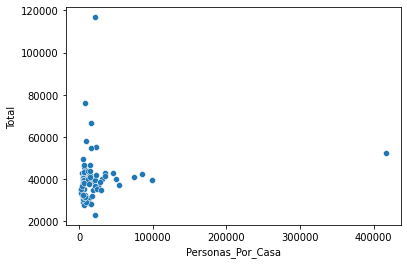

In [172]:
df_plot = df.sort_values(by='count', ascending=False)
df_plot['casas_per_capita'] =  df_plot.Poblacion / df_plot['count']
# df_plot['count'] = df_plot['count'] / df_plot['count'].max()
# df_plot.Total = df_plot.Total / df_plot.Total.max()
sns.scatterplot(data=df_plot.query('count > 3'), x='Personas_Por_Casa', y='Total')

In [173]:
df.query('Nombre=="pozuelo de alarcon"')

,Nombre,CCPP,Total,NOMBRE,Poblacion,MUNICIPIO,count,Personas_Por_Casa
69,pozuelo de alarcon,28115,116712,Pozuelo de Alarcón,87165,pozuelo de alarcon,4,21791.0


# Clustering

In [174]:

est = cluster.KMeans(n_clusters=20)
Y = pd.DataFrame(est.fit_predict(df[['Total', 'count', 'Poblacion']]), columns=['cluster ID'])
Z = pd.DataFrame(est.cluster_centers_[Y['cluster ID']], 
                 columns=['Total', 'count', 'Poblacion'])
result = pd.concat([df, Y, Z], axis=1)  


In [175]:
centroids = pd.concat([Y, Z], axis=1)
cluster_count = result.groupby('cluster ID').MUNICIPIO.agg('count')
centroids = centroids.drop_duplicates().sort_values(by='cluster ID')
centroids.Total = centroids.Total.apply(np.round)
centroids['count'] = centroids['count'].apply(lambda x: np.round(x, decimals=2))
centroids.reset_index(drop=True, inplace=True)
centroids = pd.concat([centroids, cluster_count], axis=1)
centroids.sort_values(by='Total', ascending=False, inplace=True)
centroids.reset_index(drop=True, inplace=True)
centroids['Poblacion'] = np.round(centroids['Poblacion'] / 1000)
centroids.rename(columns={'Total': 'Renta Bruta Media', 'count': 'Puntos de Apuesta', 'cluster ID': 'Cluster', 'MUNICIPIO': 'Municipios Por Cluster', 'Poblacion': 'Poblacion En Miles'}, inplace=True)
centroids

,Cluster,Renta Bruta Media,Puntos de Apuesta,Poblacion En Miles,Municipios Por Cluster
0,16,116712.0,4.00,87.0,1
1,11,88334.0,1.00,43.0,3
2,17,76152.0,14.00,118.0,1
3,1,55136.0,149.00,3335.0,1
4,3,52645.0,4.00,1664.0,1
5,19,50332.0,2.40,28.0,10
6,5,44053.0,8.41,94.0,17
7,10,42475.0,110.00,800.0,1
8,0,42304.0,11.00,183.0,10
9,6,41369.0,32.00,338.0,2


<AxesSubplot:xlabel='Puntos de Apuesta', ylabel='Renta Bruta Media'>

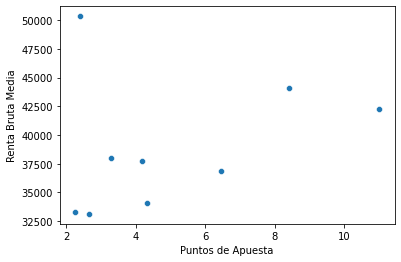

In [178]:
sns.scatterplot(data=centroids.query('`Municipios Por Cluster` > 5'), x='Puntos de Apuesta', y='Renta Bruta Media')

In [123]:
result.query('`cluster ID`==2')

,Nombre,CCPP,Total,NOMBRE,Poblacion,MUNICIPIO,count,Personas_Por_Casa,cluster ID,Total,count
18,benidorm,03031,29224,Benidorm,70450,benidorm,14,5032.0,2,29296.590164,1.860656
37,sarria,27057,30041,Sarria,13338,sarria,9,1482.0,2,29296.590164,1.860656
42,elda,03066,27778,Elda,52813,elda,8,6602.0,2,29296.590164,1.860656
57,fuengirola,29054,28924,Fuengirola,82837,fuengirola,6,13806.0,2,29296.590164,1.860656
63,talavera de la reina,45165,31086,Talavera de la Reina,83663,talavera de la reina,6,13944.0,2,29296.590164,1.860656
...,...,...,...,...,...,...,...,...,...,...,...
456,guitiriz,27022,30790,Guitiriz,5490,guitiriz,1,5490.0,2,29296.590164,1.860656
457,churriana de la vega,18062,30818,Churriana de la Vega,15689,churriana de la vega,1,15689.0,2,29296.590164,1.860656
458,aldea del fresno,28008,30833,Aldea del Fresno,2973,aldea del fresno,1,2973.0,2,29296.590164,1.860656
459,coristanco,15029,30912,Coristanco,5950,coristanco,1,5950.0,2,29296.590164,1.860656


In [72]:
result

,Nombre,CCPP,Total,NOMBRE,Poblacion,MUNICIPIO,count,Personas_Por_Casa,cluster ID,Total,Poblacion,count
0,madrid,28079,17030,Madrid,3334730,madrid,149,22381.0,1,17030.000000,3.334730e+06,149.000000
1,valencia,46250,13643,València,800215,valencia,110,7275.0,7,13387.666667,7.244957e+05,41.666667
2,"coruña, a",15030,14536,"Coruña, A",247604,"coruña, a",59,4197.0,5,13766.500000,2.893599e+05,23.625000
3,vitoria-gasteiz,01059,15291,Vitoria-Gasteiz,253996,vitoria-gasteiz,52,4885.0,5,13766.500000,2.893599e+05,23.625000
4,bilbao,48020,16119,Bilbao,350184,bilbao,51,6866.0,5,13766.500000,2.893599e+05,23.625000
...,...,...,...,...,...,...,...,...,...,...,...,...
529,tavernes de la valldigna,46238,11515,Tavernes de la Valldigna,17254,tavernes de la valldigna,1,17254.0,2,11327.519878,7.931789e+03,1.755352
530,almodovar del campo,13015,11553,Almodóvar del Campo,5983,almodovar del campo,1,5983.0,2,11327.519878,7.931789e+03,1.755352
531,ribas de sil,27052,11569,Ribas de Sil,931,ribas de sil,1,931.0,2,11327.519878,7.931789e+03,1.755352
532,cabezon de la sal,39012,11581,Cabezón de la Sal,8358,cabezon de la sal,1,8358.0,2,11327.519878,7.931789e+03,1.755352
